# Financial derivatives proposal 

Rodrigo Hernández Mota | Daniela Guerra Alcalá | Yolanda Rodriguez Cañedo 

In [3]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from financial_series.everything import *

## Download Asset Prices 

In [4]:
_from = dt.datetime.strftime(dt.datetime.now() - dt.timedelta(days=360),'%Y/%m/%d')
_now  = dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d')

asset = Currency(units='MXN', base = 'USD', t0 = _from, tf = _now)
asset.fill()

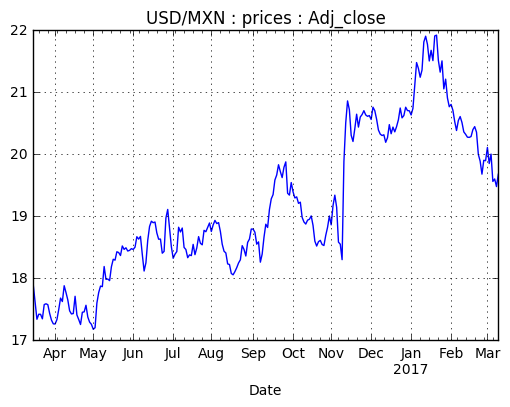

In [5]:
asset.plot()
plt.grid()

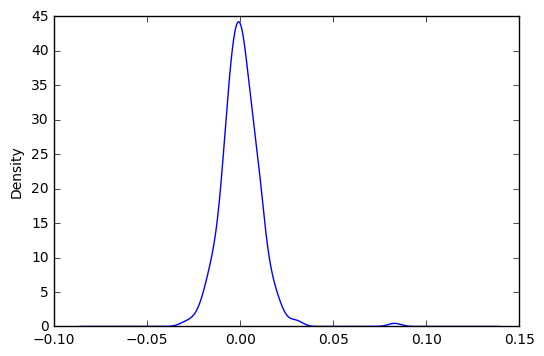

In [6]:
random_variable = asset.returns.Adj_close.plot(kind='kde')
x_val, y_val    = random_variable.get_children()[0]._x, random_variable.get_children()[0]._y

random_variable = pd.DataFrame({'x':x_val,'density':y_val})

In [7]:
acum = 0
acum_vect = []
for d in random_variable.density:
    acum += d
    acum_vect.append(acum)

random_variable['cumulative'] = np.array(acum_vect)/acum

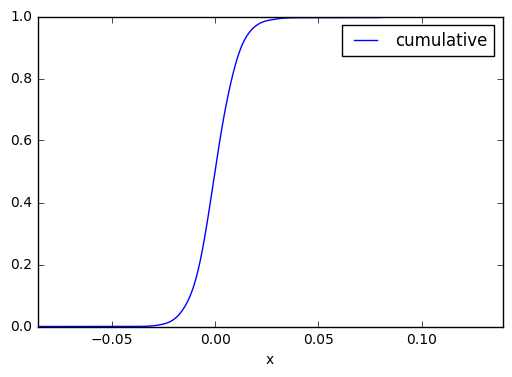

In [8]:
random_variable.plot(x='x',y='cumulative')

In [9]:
def getRandomValue(reference):
    unif = np.random.uniform()
    index = sum(reference.cumulative < unif)
    return reference.x.iloc[index]

def getRandomVect(n,reference):
    return np.array([getRandomValue(reference) for i in range(n)])

# Kernel Density Estimator

In [10]:
np.random.uniform()

0.15499682631763834

## Define function for trajectories 

In [11]:
S0 = asset.prices.Adj_close.iloc[-1]

In [12]:
def mTrajectoriesKde(S0=100,T=1,n=360,m=1):
    rnd = list(map(lambda x: getRandomVect(n,random_variable),range(m)))
    log_increment = [np.concatenate([np.array([np.log(S0)]),i]) for i in rnd]
    log_path      = [np.cumsum(i) for i in log_increment]
    return pd.DataFrame(np.asmatrix([np.exp(i) for i in log_path]).T)

def mTrajectoriesNormal(S0=100,mu=0,sigma=0.2,T=1,n=360,m=1):
    dt = T/n
    mu_t, sigma_t = (mu-sigma**2/2)*dt, sigma*np.sqrt(dt)
    rnd = list(map(lambda x: np.random.normal(mu_t,sigma_t,n),range(m)))
    log_increment = [np.concatenate([np.array([np.log(S0)]),i]) for i in rnd]
    log_path      = [np.cumsum(i) for i in log_increment]
    return pd.DataFrame(np.asmatrix([np.exp(i) for i in log_path]).T)

In [13]:
simul_kde    = mTrajectoriesKde(S0=S0,m=50)
simul_normal = mTrajectoriesNormal(S0=S0,m=50,mu=asset.returns.Adj_close.mean(),sigma=asset.returns.Adj_close.std())

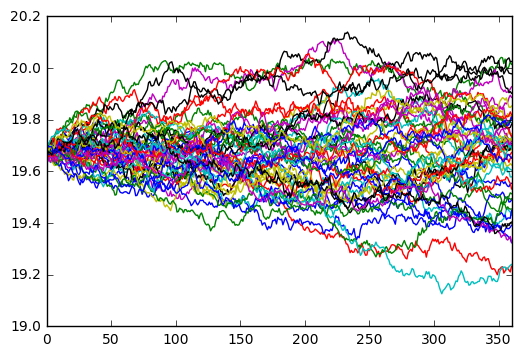

In [14]:
simul_normal.plot(legend=False)

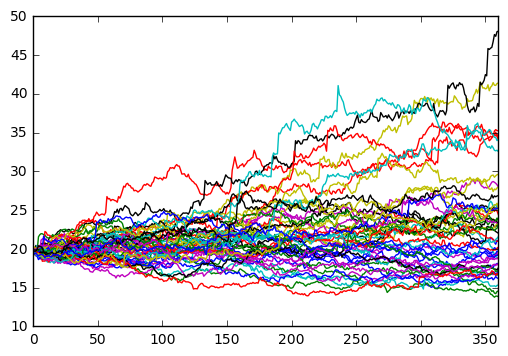

In [15]:
simul_kde.plot(legend=False)

## Proposal


In [16]:

def matchValueWithAlpha(value,vect,tol=10000):
    not_found = True 
    vect  = np.array(vect)
    value = 0
    n = len(vect)
    while(not_found):
        probability = sum(vect < value) / n
        if probability < alpha:
            value += 0.1
            tol -= 1
        else: 
            not_found=False 
        if not tol:
            print('Error: tolerance limit reached')
            return None
            
    return value





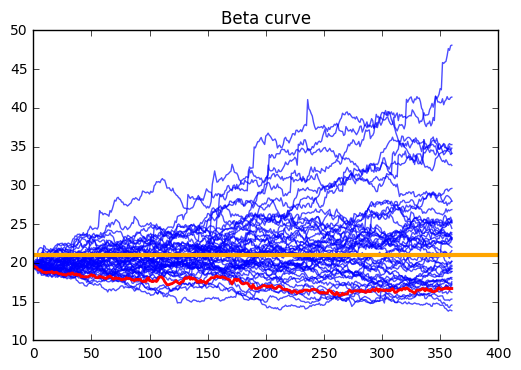

In [17]:
df = simul_kde
k = 21

alpha = 0.10
beta_line = df.apply(lambda x: matchValueWithAlpha(value=alpha,vect=x),1)
for cols in df:
    plt.plot(df[cols],'b',alpha=0.7)
plt.plot(beta_line.values,'r',linewidth=2)
plt.axhline(y=k,xmin=0,xmax=len(df),color='orange',linewidth=3)
plt.title('Beta curve')
plt.show()

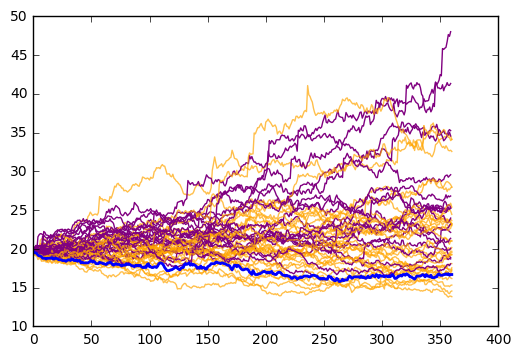

In [18]:
for t in df:
    
    ref = 0
    cond = True
    while(cond):
        ref += 1
        if df[t].iloc[ref]<beta_line.iloc[ref]:
            cond = False
        if ref == len(df)-1:
            break
    plt.plot(df[t].iloc[:ref].index.values,df[t].iloc[:ref].values,'purple',alpha=1)
    plt.plot(df[t].iloc[ref:].index.values,df[t].iloc[ref:].values,'orange',alpha=0.7)
    
plt.plot(beta_line.values,'blue',linewidth=2)
plt.show()
    